### Imports

In [4]:
from definitions import *

### Make quiz prompt

In [5]:
with open("../../metrics/knowledge_tests/obrazovaka/oblomov.json", "r") as f:
    quiz = json.load(f)

In [6]:
part = quiz[0]
part

{'question': 'К какому литературному направлению относится роман Гончарова «Обломов»?',
 'answers': [{'answer': 'Романтизм;', 'is_correct': 0},
  {'answer': 'Реализм;', 'is_correct': 1},
  {'answer': 'Классицизм;', 'is_correct': 0},
  {'answer': 'Сентиментализм.', 'is_correct': 0}]}

In [4]:
def build_prompt(quiz_part):
    processed_answers = ""
    for i, answer in enumerate(quiz_part["answers"]):
        processed_answers += f"{i + 1}. {answer['answer']}\n"
    # return f"Выбери один верный вариант из предложенных.\nВопрос: {quiz_part['question']}\nВарианты ответа:\n{processed_answers}"
    return f"Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.\nВопрос: {quiz_part['question']}\nВарианты ответа:\n{processed_answers}"

In [5]:
print(build_prompt(part))

Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.
Вопрос: К какому литературному направлению относится роман Гончарова «Обломов»?
Варианты ответа:
1. Романтизм;
2. Реализм;
3. Классицизм;
4. Сентиментализм.



In [54]:
def build_prompt_with_summary(quiz_part, summary):
    processed_answers = ""
    for i, answer in enumerate(quiz_part["answers"]):
        processed_answers += f"{i + 1}. {answer['answer']}\n"
    # return f"Выбери один верный вариант из предложенных.\nВопрос: {quiz_part['question']}\nВарианты ответа:\n{processed_answers}"
    return f"Внимательно прочитай краткое содержание книги, и потом ответь на вопрос.\nКраткое содержание:\n{summary}\nВыбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.\nВопрос: {quiz_part['question']}\nВарианты ответа:\n{processed_answers}"

In [55]:
print(build_prompt_with_summary(part, "kek"))

Внимательно прочитай краткое содержание книги, и потом ответь на вопрос.
Краткое содержание:
kek
Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.
Вопрос: В чем автор видит причины «обломовщины»?
Варианты ответа:
1. В деградации и застое чистой, нерасчетливой, нежной, но ленивой души героя;
2. В окружении героя, которое не давало ему развиваться;
3. В недостаточно хорошем образовании героя;
4. В отсутствии достойных стимулов к развитию.



In [56]:
import copy

def build_json_prompt(quiz_part):
    sample_quiz_part = {
        "question": "вопрос",
        "answers": [
        {
            "answer": "ответ1"
        },
        {
            "answer": "ответ2"
        },
        {
            "answer": "ответ3"
        },
        {
            "answer": "ответ4"
        }
        ]
    }
    sample_quiz_part_answer = {
        "question": "вопрос",
        "answers": [
        {
            "answer": "ответ1",
            "is_correct": 0
        },
        {
            "answer": "ответ2",
            "is_correct": 0
        },
        {
            "answer": "ответ3",
            "is_correct": 0
        },
        {
            "answer": "ответ4",
            "is_correct": 1
        }
        ]
    }
    sample = f"Пример нашего взаимодействия. Я даю тебе json:\n{json.dumps(sample_quiz_part, indent=2, ensure_ascii=False)}\nВариант твоего ответа:\n{json.dumps(sample_quiz_part_answer, indent=2, ensure_ascii=False)}"
    quiz_part_copy = copy.deepcopy(quiz_part)
    for a in quiz_part_copy["answers"]:
        del a["is_correct"]
    return f"{sample}\nПосмотри на json который я тебе дал. Он содержит вопрос с четырьмя вариантами ответа на него. Твоя задача модифицировать этот json так, чтобы рядом с каждым вариантом ответа появилось поле 'is_correct' которое равно либо 1, либо 0 (соответственно правильный ответ или нет). В качестве ответа отправь мне только этот json и ничего больше. Твой ответ должен обрабатываться без ошибок если я вызову на нем json.loads(output) из python3, где output — твой ответ. Отмечу, что на каждый вопрос из четырех вариантов ответа правильным является ровно один.\nВот сам json, который то должен модифицировать:\n{json.dumps(quiz_part_copy, indent=2, ensure_ascii=False)}"

In [57]:
prompt = build_json_prompt(part)
print(prompt)

Пример нашего взаимодействия. Я даю тебе json:
{
  "question": "вопрос",
  "answers": [
    {
      "answer": "ответ1"
    },
    {
      "answer": "ответ2"
    },
    {
      "answer": "ответ3"
    },
    {
      "answer": "ответ4"
    }
  ]
}
Вариант твоего ответа:
{
  "question": "вопрос",
  "answers": [
    {
      "answer": "ответ1",
      "is_correct": 0
    },
    {
      "answer": "ответ2",
      "is_correct": 0
    },
    {
      "answer": "ответ3",
      "is_correct": 0
    },
    {
      "answer": "ответ4",
      "is_correct": 1
    }
  ]
}
Посмотри на json который я тебе дал. Он содержит вопрос с четырьмя вариантами ответа на него. Твоя задача модифицировать этот json так, чтобы рядом с каждым вариантом ответа появилось поле 'is_correct' которое равно либо 1, либо 0 (соответственно правильный ответ или нет). В качестве ответа отправь мне только этот json и ничего больше. Твой ответ должен обрабатываться без ошибок если я вызову на нем json.loads(output) из python3, где outp

In [63]:
import copy

def build_json_promp_full_quiz(quiz):
    sample_quiz = [{
        "question": "вопрос1",
        "answers": [
        {
            "answer": "ответ1"
        },
        {
            "answer": "ответ2"
        },
        {
            "answer": "ответ3"
        },
        {
            "answer": "ответ4"
        }
        ]
    },
    {
        "question": "вопрос2",
        "answers": [
        {
            "answer": "ответ1"
        },
        {
            "answer": "ответ2"
        },
        {
            "answer": "ответ3"
        },
        {
            "answer": "ответ4"
        }
        ]
    }]
    sample_quiz_answer = [{
        "question": "вопрос1",
        "answers": [
        {
            "answer": "ответ1",
            "is_correct": 0
        },
        {
            "answer": "ответ2",
            "is_correct": 0
        },
        {
            "answer": "ответ3",
            "is_correct": 0
        },
        {
            "answer": "ответ4",
            "is_correct": 1
        }
        ]
    },
    {
        "question": "вопрос2",
        "answers": [
        {
            "answer": "ответ1",
            "is_correct": 0
        },
        {
            "answer": "ответ2",
            "is_correct": 1
        },
        {
            "answer": "ответ3",
            "is_correct": 0
        },
        {
            "answer": "ответ4",
            "is_correct": 0
        }
        ]
    }]
    sample = f"Пример нашего взаимодействия. Я даю тебе json:\n{json.dumps(sample_quiz, indent=2, ensure_ascii=False)}\nВариант твоего ответа:\n{json.dumps(sample_quiz_answer, indent=2, ensure_ascii=False)}"
    quiz_copy = copy.deepcopy(quiz)
    for qa in quiz_copy:
        for a in qa["answers"]:
            del a["is_correct"]
    return f"{sample}\nПосмотри на json который я тебе дал. Он содержит вопрос с четырьмя вариантами ответа на него. Твоя задача модифицировать этот json так, чтобы рядом с каждым вариантом ответа появилось поле 'is_correct' которое равно либо 1, либо 0 (соответственно правильный ответ или нет). В качестве ответа отправь мне только этот json и ничего больше. Твой ответ должен обрабатываться без ошибок если я вызову на нем json.loads(output) из python3, где output — твой ответ. Отмечу, что на каждый вопрос из четырех вариантов ответа правильным является ровно один.\nВот сам json, который то должен модифицировать:\n{json.dumps(quiz_copy, indent=2, ensure_ascii=False)}"

In [80]:
prompt = build_json_promp_full_quiz(quiz)
print(prompt)

Пример нашего взаимодействия. Я даю тебе json:
[
  {
    "question": "вопрос1",
    "answers": [
      {
        "answer": "ответ1"
      },
      {
        "answer": "ответ2"
      },
      {
        "answer": "ответ3"
      },
      {
        "answer": "ответ4"
      }
    ]
  },
  {
    "question": "вопрос2",
    "answers": [
      {
        "answer": "ответ1"
      },
      {
        "answer": "ответ2"
      },
      {
        "answer": "ответ3"
      },
      {
        "answer": "ответ4"
      }
    ]
  }
]
Вариант твоего ответа:
[
  {
    "question": "вопрос1",
    "answers": [
      {
        "answer": "ответ1",
        "is_correct": 0
      },
      {
        "answer": "ответ2",
        "is_correct": 0
      },
      {
        "answer": "ответ3",
        "is_correct": 0
      },
      {
        "answer": "ответ4",
        "is_correct": 1
      }
    ]
  },
  {
    "question": "вопрос2",
    "answers": [
      {
        "answer": "ответ1",
        "is_correct": 0
      },
      

In [83]:
get_model_response("gemma:7b", prompt)

''

### Learn to make requests to ollama

In [1]:
! ollama list

NAME                    	ID          	SIZE  	MODIFIED   
dolphin-phi:latest      	c5761fc77240	1.6 GB	4 days ago	
gemma:2b                	b50d6c999e59	1.7 GB	4 days ago	
gemma:7b                	a72c7f4d0a15	5.0 GB	4 days ago	
llama2:13b              	d475bf4c50bc	7.4 GB	4 days ago	
llama2:70b              	e7f6c06ffef4	38 GB 	3 days ago	
llama2:latest           	78e26419b446	3.8 GB	4 days ago	
llama2-uncensored:latest	44040b922233	3.8 GB	4 days ago	
llama3:70b              	bcfb190ca3a7	39 GB 	3 days ago	
llama3:latest           	71a106a91016	4.7 GB	4 days ago	
llava:latest            	8dd30f6b0cb1	4.7 GB	4 days ago	
mistral:latest          	61e88e884507	4.1 GB	4 days ago	
neural-chat:latest      	89fa737d3b85	4.1 GB	4 days ago	
orca-mini:latest        	2dbd9f439647	2.0 GB	4 days ago	
phi:latest              	e2fd6321a5fe	1.6 GB	4 days ago	
solar:latest            	059fdabbe6e6	6.1 GB	4 days ago	
starling-lm:latest      	39153f619be6	4.1 GB	4 days ago	


In [82]:
def get_model_response(model, prompt):
    headers = {
        'Content-Type': 'application/json',
    }
    json_data = {
        'model': model,
        'prompt': prompt,
        'stream': False,
        "options": {
            "seed": 123,
            "temperature": 0
        }
    }

    response = requests.post('http://localhost:11434/api/generate', headers=headers, json=json_data)
    payload = json.loads(response.content)
    return payload["response"]

In [48]:
get_model_response("llama3", "say hi")

"Hi! How's it going?"

### Pass quiz in json format with different models

In [78]:
def eval_model_on_quiz(model, quiz, summary=None):
    num_ok = 0
    num_all = len(quiz)
    prompt = build_json_promp_full_quiz(quiz)
    response = get_model_response(model, prompt)
    try:
        answer = json.loads(response)
    except Exception:
        print(response)
        print(f"{model} gave answer not in json format")
    try:
        for part_quiz, part_answer in zip(quiz, answer):
            fail_current = 0
            for i, x in enumerate(part_quiz["answers"]):
                if x["is_correct"] != part_answer[i].get("is_correct", -1):
                    fail_current = 1
                    break
            if fail_current:
                continue
            num_ok += 1
    except Exception:
        pass
            
    print(f"result is {num_ok} out of {num_all}. {num_ok / num_all * 100:.2f}%")
    return num_ok, num_all

In [79]:
eval_model_on_quiz("gemma:7b", quiz)


gemma:7b gave answer not in json format
result is 0 out of 19. 0.00%


(0, 19)

### Try to pass quiz with a model

In [16]:
prompt = build_prompt(part)
print(prompt)
get_model_response(model, prompt)

Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.
Вопрос: В чем автор видит причины «обломовщины»?
Варианты ответа:
1. В деградации и застое чистой, нерасчетливой, нежной, но ленивой души героя;
2. В окружении героя, которое не давало ему развиваться;
3. В недостаточно хорошем образовании героя;
4. В отсутствии достойных стимулов к развитию.



'1.'

In [17]:
len(quiz)

19

In [56]:
def eval_model_on_quiz(model, quiz, summary=None):
    num_ok = 0
    num_all = 0
    for part in tqdm(quiz):
        if summary:
            prompt = build_prompt_with_summary(part, summary)
        else:
            prompt = build_prompt(part)
        answer = get_model_response(model, prompt)
        first_part = answer.split()[0]
        if first_part.endswith("."):
            first_part = first_part[:-1]
        ok_answer = -1
        for i, x in enumerate(part["answers"]):
            if x["is_correct"] == 1:
                ok_answer = i + 1
        try:
            first_part = int(first_part)
        except Exception:
            print(f"Cannot convert model first part answer to int: '{answer}'")
        if ok_answer == first_part:
            num_ok += 1
        num_all += 1
    print(f"result is {num_ok} out of {num_all}. {num_ok / num_all * 100:.2f}%")
    return num_ok, num_all

In [59]:
models = ["llama2", "llama3"]
rows = []
for model in models:
    tests_dir = Path("../../metrics/knowledge_tests/obrazovaka/")
    for test_path in tests_dir.glob("*.json"):
        with open(test_path, "r") as f:
            quiz = json.load(f)
        with open(f"../../downloaded_books/briefly_summaries/very_short/{test_path.stem}.txt", "r") as f:
            summary = f.read()
        num_ok, num_all = eval_model_on_quiz(model, quiz, summary=summary)
        rows.append({
            "model": model,
            "test_path": test_path,
            "num_ok": num_ok,
            "num_all": num_all,
            "percent": float(f"{(num_ok / num_all * 100):.2f}"),
        })

100%|██████████| 16/16 [00:13<00:00,  1.18it/s]


result is 4 out of 16. 25.00%


 30%|███       | 3/10 [00:10<00:21,  3.12s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.

Варианты ответа:

1. 1'


 50%|█████     | 5/10 [00:11<00:07,  1.59s/it]

Cannot convert model first part answer to int: 'The answer is:

3. Дмитриy'


 60%|██████    | 6/10 [00:12<00:05,  1.34s/it]

Cannot convert model first part answer to int: 'The answer is:

4. Алексий'


 70%|███████   | 7/10 [00:13<00:03,  1.19s/it]

Cannot convert model first part answer to int: 'The answer is:

4. Грушенька'


100%|██████████| 10/10 [00:15<00:00,  1.52s/it]


result is 1 out of 10. 10.00%


 50%|█████     | 9/18 [00:10<00:07,  1.21it/s]

Cannot convert model first part answer to int: '4.Stepan Astahov'


100%|██████████| 18/18 [00:16<00:00,  1.09it/s]


result is 3 out of 18. 16.67%


100%|██████████| 19/19 [00:14<00:00,  1.28it/s]


result is 2 out of 19. 10.53%


100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


result is 2 out of 10. 20.00%


 54%|█████▍    | 7/13 [00:09<00:05,  1.08it/s]

Cannot convert model first part answer to int: 'Вариант ответа: 2. Он начал писать стихи'


100%|██████████| 13/13 [00:12<00:00,  1.07it/s]


Cannot convert model first part answer to int: '1.EVGRAPH ZHIVAGO'
result is 2 out of 13. 15.38%


  3%|▎         | 2/70 [00:06<03:30,  3.09s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных:
'1'.'


  4%|▍         | 3/70 [00:08<02:53,  2.60s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных:

1. '2', 'вошедшего в гостиную Анны Павловны Шерер'.'


 13%|█▎        | 9/70 [00:15<01:42,  1.69s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.

В этом случае, наиболее подходящим ответом будет:

1. с прелестным котенком'


 19%|█▊        | 13/70 [00:19<01:08,  1.20s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных:

1. главнокомандующий Кутузов'


 20%|██        | 14/70 [00:22<01:36,  1.73s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.

Ваш выбор:

1. картавость'


 29%|██▊       | 20/70 [00:26<00:45,  1.09it/s]

Cannot convert model first part answer to int: 'The answer is:

1. ИLYA ANDREYEVICH ROSTOV'


 70%|███████   | 49/70 [00:50<00:20,  1.04it/s]

Cannot convert model first part answer to int: '4.спокойное равнодушие'


 97%|█████████▋| 68/70 [01:09<00:02,  1.48s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных. В качестве ответа напиши только номер, без дополнительного текста. Например: '1', '2', '3', '4'.

В этом случае, наиболее подходящим ответом будет:

1. '1''


100%|██████████| 70/70 [01:10<00:00,  1.01s/it]


result is 14 out of 70. 20.00%


100%|██████████| 16/16 [00:13<00:00,  1.23it/s]


result is 4 out of 16. 25.00%


100%|██████████| 19/19 [00:14<00:00,  1.32it/s]


result is 3 out of 19. 15.79%


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


result is 2 out of 10. 20.00%


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


result is 3 out of 10. 30.00%


 20%|██        | 6/30 [00:09<00:29,  1.25s/it]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных:

4. Сергей Есенин'


 27%|██▋       | 8/30 [00:11<00:21,  1.04it/s]

Cannot convert model first part answer to int: '1.FEДОР ФЕДОРОВИЧ'


 43%|████▎     | 13/30 [00:15<00:16,  1.01it/s]

Cannot convert model first part answer to int: 'Выбери один верный вариант из предложенных:

1. "Почему она не шевелится?"'


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]


Cannot convert model first part answer to int: '1.十 дней'
result is 6 out of 30. 20.00%


100%|██████████| 12/12 [00:13<00:00,  1.09s/it]


result is 3 out of 12. 25.00%


100%|██████████| 16/16 [00:15<00:00,  1.04it/s]


result is 3 out of 16. 18.75%


100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


result is 2 out of 10. 20.00%


100%|██████████| 16/16 [00:52<00:00,  3.27s/it]


result is 8 out of 16. 50.00%


100%|██████████| 10/10 [00:12<00:00,  1.25s/it]


result is 7 out of 10. 70.00%


100%|██████████| 18/18 [00:13<00:00,  1.35it/s]


result is 11 out of 18. 61.11%


100%|██████████| 19/19 [00:14<00:00,  1.29it/s]


result is 14 out of 19. 73.68%


100%|██████████| 10/10 [00:09<00:00,  1.05it/s]


result is 1 out of 10. 10.00%


100%|██████████| 13/13 [00:10<00:00,  1.23it/s]


result is 7 out of 13. 53.85%


100%|██████████| 70/70 [00:49<00:00,  1.42it/s]


result is 34 out of 70. 48.57%


100%|██████████| 16/16 [00:11<00:00,  1.34it/s]


result is 10 out of 16. 62.50%


100%|██████████| 19/19 [00:16<00:00,  1.12it/s]


result is 10 out of 19. 52.63%


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


result is 6 out of 10. 60.00%


100%|██████████| 10/10 [00:09<00:00,  1.06it/s]


result is 6 out of 10. 60.00%


100%|██████████| 30/30 [00:22<00:00,  1.36it/s]


result is 11 out of 30. 36.67%


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


result is 6 out of 12. 50.00%


100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


result is 10 out of 16. 62.50%


100%|██████████| 10/10 [00:08<00:00,  1.14it/s]

result is 5 out of 10. 50.00%


In [43]:
# for row in rows:
    # row["percent"] = float(f'{(row["num_ok"] / row["num_all"] * 100):.2f}')

In [60]:
df = pd.DataFrame(rows)
df.to_csv("some_results_briefly.csv")
df

,model,test_path,num_ok,num_all,percent
0,llama2,../../metrics/knowledge_tests/obrazovaka/the_d...,4,16,25.00
1,llama2,../../metrics/knowledge_tests/obrazovaka/the_b...,1,10,10.00
2,llama2,../../metrics/knowledge_tests/obrazovaka/and_q...,3,18,16.67
3,llama2,../../metrics/knowledge_tests/obrazovaka/oblom...,2,19,10.53
4,llama2,../../metrics/knowledge_tests/obrazovaka/eveni...,2,10,20.00
5,llama2,../../metrics/knowledge_tests/obrazovaka/docto...,2,13,15.38
6,llama2,../../metrics/knowledge_tests/obrazovaka/war_a...,14,70,20.00
7,llama2,../../metrics/knowledge_tests/obrazovaka/the_m...,4,16,25.00
8,llama2,../../metrics/knowledge_tests/obrazovaka/dead_...,3,19,15.79
9,llama2,../../metrics/knowledge_tests/obrazovaka/the_g...,2,10,20.00


In [61]:
models = ["llama2", "llama3"]
rows_stupid = []
for model in models:
    tests_dir = Path("../../metrics/knowledge_tests/obrazovaka/")
    for test_path in tests_dir.glob("*.json"):
        with open(test_path, "r") as f:
            quiz = json.load(f)
        with open(f"../../downloaded_books/stupid_summaries/{test_path.stem}.txt", "r") as f:
            summary = f.read()
        num_ok, num_all = eval_model_on_quiz(model, quiz, summary=summary)
        rows_stupid.append({
            "model": model,
            "test_path": test_path,
            "num_ok": num_ok,
            "num_all": num_all,
            "percent": float(f"{(num_ok / num_all * 100):.2f}"),
        })
df_stupid = pd.DataFrame(rows_stupid)
df_stupid

100%|██████████| 16/16 [00:16<00:00,  1.04s/it]


result is 4 out of 16. 25.00%


 30%|███       | 3/10 [00:03<00:07,  1.04s/it]

Cannot convert model first part answer to int: 'Okay, I've read the summary, and my answer is:

1.'


100%|██████████| 10/10 [00:06<00:00,  1.58it/s]


result is 3 out of 10. 30.00%


100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


result is 4 out of 18. 22.22%


100%|██████████| 19/19 [00:17<00:00,  1.09it/s]


result is 2 out of 19. 10.53%


100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


result is 2 out of 10. 20.00%


100%|██████████| 13/13 [00:07<00:00,  1.63it/s]


result is 3 out of 13. 23.08%


100%|██████████| 70/70 [00:38<00:00,  1.82it/s]


result is 16 out of 70. 22.86%


100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


result is 5 out of 16. 31.25%


100%|██████████| 19/19 [00:11<00:00,  1.66it/s]


result is 7 out of 19. 36.84%


100%|██████████| 10/10 [00:05<00:00,  1.74it/s]


result is 1 out of 10. 10.00%


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


Cannot convert model first part answer to int: '4.Bracket'
result is 2 out of 10. 20.00%


 40%|████      | 12/30 [00:11<00:19,  1.09s/it]

Cannot convert model first part answer to int: 'Вариант ответа: 2. Потому что считал доктора Борменталя глупым.'


100%|██████████| 30/30 [00:27<00:00,  1.11it/s]


Cannot convert model first part answer to int: '4.十 лет'
result is 5 out of 30. 16.67%


100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


result is 3 out of 12. 25.00%


100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


result is 5 out of 16. 31.25%


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


result is 3 out of 10. 30.00%


100%|██████████| 16/16 [00:16<00:00,  1.01s/it]


result is 5 out of 16. 31.25%


100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


result is 3 out of 10. 30.00%


 78%|███████▊  | 14/18 [00:11<00:04,  1.18s/it]

Cannot convert model first part answer to int: 'В книге "Война и мир" Льва Толстого нет персонажа по имени Наталья, а также нет сцены, где женщина решает избавиться от нерожденного ребенка Григория. Поэтому ответ - не из предложенных вариантов.'


100%|██████████| 18/18 [00:13<00:00,  1.34it/s]


result is 8 out of 18. 44.44%


100%|██████████| 19/19 [00:11<00:00,  1.59it/s]


result is 10 out of 19. 52.63%


 10%|█         | 1/10 [00:03<00:33,  3.73s/it]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к Гоголю и его циклу "Вечера на хуторе близ Диканьки")'


 20%|██        | 2/10 [00:05<00:18,  2.32s/it]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о селе, представленном в произведениях Гоголя) -> 0'


 30%|███       | 3/10 [00:06<00:12,  1.73s/it]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к указанным годам)'


 40%|████      | 4/10 [00:07<00:09,  1.52s/it]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о жизни и творчестве Гоголя) -> 0'


 50%|█████     | 5/10 [00:08<00:07,  1.44s/it]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о поддержке литературных начинаний Гоголя) -> 0'


100%|██████████| 10/10 [00:10<00:00,  1.09s/it]


Cannot convert model first part answer to int: 'None of the above (нет из выбранных вариантов)'
result is 0 out of 10. 0.00%


 31%|███       | 4/13 [00:04<00:08,  1.06it/s]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к роману "Юрый Живаго")'


100%|██████████| 13/13 [00:07<00:00,  1.66it/s]


result is 6 out of 13. 46.15%


  6%|▌         | 4/70 [00:06<01:41,  1.54s/it]

Cannot convert model first part answer to int: 'В книге не описывается встреча Наполеона с казаком, поэтому ответ на вопрос не соответствует содержанию книги.

Таким образом, я выберу вариант '4' (ошибка в вопросе).'


  9%|▊         | 6/70 [00:08<01:12,  1.13s/it]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 13%|█▎        | 9/70 [00:09<00:48,  1.25it/s]

Cannot convert model first part answer to int: 'None of the above (нет из предложенных вариантов)'


 14%|█▍        | 10/70 [00:11<00:56,  1.06it/s]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о Наташе Ростовой и ее любви)'


 17%|█▋        | 12/70 [00:13<01:01,  1.07s/it]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к князю Андрею Болконскому и его жене Лизе)'


 23%|██▎       | 16/70 [00:15<00:41,  1.31it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 30%|███       | 21/70 [00:19<00:39,  1.23it/s]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к роману "Война и мир" Льва Толстого)'


 33%|███▎      | 23/70 [00:20<00:34,  1.37it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 34%|███▍      | 24/70 [00:22<00:50,  1.10s/it]

Cannot convert model first part answer to int: 'Нет ответа, потому что вопрос не относится к тексту книги. В тексте нет упоминания о Николае Ростове и Долохове, поэтому выбрать правильный вариант невозможно.'


 36%|███▌      | 25/70 [00:23<00:51,  1.13s/it]

Cannot convert model first part answer to int: 'None of the above (книга не содержит сцену, описанную в вопросе)'


 37%|███▋      | 26/70 [00:24<00:52,  1.20s/it]

Cannot convert model first part answer to int: 'None of the above (книга не описывает ситуацию, связанную с Пьером и Элен)'


 43%|████▎     | 30/70 [00:28<00:43,  1.09s/it]

Cannot convert model first part answer to int: 'None of the options are correct, as the text does not mention Pjotr Bezukhov or his involvement with Freemasonry. The correct answer is "None".'


 46%|████▌     | 32/70 [00:30<00:35,  1.06it/s]

Cannot convert model first part answer to int: 'None of the above (книга не описывает танец)'


 49%|████▊     | 34/70 [00:31<00:32,  1.10it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 51%|█████▏    | 36/70 [00:33<00:30,  1.10it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 69%|██████▊   | 48/70 [00:41<00:15,  1.38it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных)'


 77%|███████▋  | 54/70 [00:46<00:13,  1.16it/s]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к Николаю Ростову и княжне Марье)'


 80%|████████  | 56/70 [00:47<00:12,  1.08it/s]

Cannot convert model first part answer to int: 'None of the options are correct, as the text does not mention Prince Andrei or his pre-mortem dream. The correct answer is "None".'


 86%|████████▌ | 60/70 [00:50<00:06,  1.45it/s]

Cannot convert model first part answer to int: 'None of the above (нет из предложенных вариантов)'


 87%|████████▋ | 61/70 [00:52<00:10,  1.15s/it]

Cannot convert model first part answer to int: 'Нет ответа, потому что вопрос не относится к тексту книги "Письмо". В тексте не упоминается семья Ростовых и Петя. therefore, the correct answer is None of the above (0).'


 93%|█████████▎| 65/70 [00:54<00:04,  1.23it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 94%|█████████▍| 66/70 [00:56<00:03,  1.06it/s]

Cannot convert model first part answer to int: 'None of the above (книга не имеет отношения к Наташе Ростовой и ее браку)'


 96%|█████████▌| 67/70 [00:57<00:02,  1.04it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


 97%|█████████▋| 68/70 [00:58<00:02,  1.20s/it]

Cannot convert model first part answer to int: 'None of the options are correct, as this question is not related to the text about Napoleon's letter. The correct answer would be "none" or "not applicable".'


100%|██████████| 70/70 [00:59<00:00,  1.17it/s]


result is 23 out of 70. 32.86%


100%|██████████| 16/16 [00:09<00:00,  1.69it/s]


result is 4 out of 16. 25.00%


100%|██████████| 19/19 [00:10<00:00,  1.83it/s]


result is 4 out of 19. 21.05%


100%|██████████| 10/10 [00:05<00:00,  1.90it/s]


result is 5 out of 10. 50.00%


 30%|███       | 3/10 [00:04<00:08,  1.19s/it]

Cannot convert model first part answer to int: 'None of the above (ответ не связан с вопросом)'


 60%|██████    | 6/10 [00:05<00:02,  1.44it/s]

Cannot convert model first part answer to int: 'None of the above (нет из какого города)'


 80%|████████  | 8/10 [00:06<00:01,  1.56it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных)'


 90%|█████████ | 9/10 [00:07<00:00,  1.47it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных)'


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


result is 2 out of 10. 20.00%


100%|██████████| 30/30 [00:16<00:00,  1.77it/s]


result is 13 out of 30. 43.33%


 42%|████▏     | 5/12 [00:04<00:06,  1.11it/s]

Cannot convert model first part answer to int: 'В кратком содержании книги не упоминается Мышкин и Рогожин, поэтому ответ - 4 (нет соответствия).'


 67%|██████▋   | 8/12 [00:07<00:03,  1.00it/s]

Cannot convert model first part answer to int: 'None of the above (книга "Ма Рабе" не имеет отношения к Мышкину и Рогожину, поэтому ответ - 0)'


 75%|███████▌  | 9/12 [00:08<00:02,  1.04it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных)'


 92%|█████████▏| 11/12 [00:09<00:00,  1.17it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных вариантов)'


100%|██████████| 12/12 [00:10<00:00,  1.17it/s]


result is 3 out of 12. 25.00%


  6%|▋         | 1/16 [00:04<01:14,  4.96s/it]

Cannot convert model first part answer to int: 'None of the options are correct, as the book is not about Dostoevsky's "Crime and Punishment". The question seems to be unrelated to the content of the book.

So, I'll leave it blank:'


 38%|███▊      | 6/16 [00:09<00:15,  1.52s/it]

Cannot convert model first part answer to int: 'None of the options are correct because the text does not mention Rascolnikov or any characters from a novel. The text appears to be a collection of phrases and expressions related to clothing, textiles, and appearance. Therefore, I would answer: None (0)'


 62%|██████▎   | 10/16 [00:13<00:07,  1.25s/it]

Cannot convert model first part answer to int: 'None of the options are correct, as the text does not mention Rodion Raskolnikov or his idol. The correct answer is not among the provided options.

Correct answer: None (the question is unrelated to the text)'


100%|██████████| 16/16 [00:17<00:00,  1.08s/it]


result is 7 out of 16. 43.75%


 40%|████      | 4/10 [00:03<00:04,  1.36it/s]

Cannot convert model first part answer to int: 'None of the above (нет из вышеперечисленных)'


 70%|███████   | 7/10 [00:05<00:02,  1.40it/s]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о графе Вронском) -> 0'


 80%|████████  | 8/10 [00:06<00:01,  1.12it/s]

Cannot convert model first part answer to int: 'None of the above (книга не содержит информации о Левине и Ките) -> нет ответа из предложенных вариантов.'


100%|██████████| 10/10 [00:07<00:00,  1.35it/s]

result is 4 out of 10. 40.00%


,model,test_path,num_ok,num_all,percent
0,llama2,../../metrics/knowledge_tests/obrazovaka/the_d...,4,16,25.00
1,llama2,../../metrics/knowledge_tests/obrazovaka/the_b...,3,10,30.00
2,llama2,../../metrics/knowledge_tests/obrazovaka/and_q...,4,18,22.22
3,llama2,../../metrics/knowledge_tests/obrazovaka/oblom...,2,19,10.53
4,llama2,../../metrics/knowledge_tests/obrazovaka/eveni...,2,10,20.00
5,llama2,../../metrics/knowledge_tests/obrazovaka/docto...,3,13,23.08
6,llama2,../../metrics/knowledge_tests/obrazovaka/war_a...,16,70,22.86
7,llama2,../../metrics/knowledge_tests/obrazovaka/the_m...,5,16,31.25
8,llama2,../../metrics/knowledge_tests/obrazovaka/dead_...,7,19,36.84
9,llama2,../../metrics/knowledge_tests/obrazovaka/the_g...,1,10,10.00


In [62]:
df_stupid.to_csv("some_results_stupid.csv")

In [52]:
init_df = pd.read_csv("../../metrics/knowledge_tests/obrazovaka/full_results.csv")
full_df = pd.concat((init_df, df))
full_df

,model,test_path,num_ok,num_all,percent
0,llama2,../../metrics/knowledge_tests/obrazovaka/the_d...,3,16,18.75
1,llama2,../../metrics/knowledge_tests/obrazovaka/the_b...,1,10,10.00
2,llama2,../../metrics/knowledge_tests/obrazovaka/and_q...,6,18,33.33
3,llama2,../../metrics/knowledge_tests/obrazovaka/oblom...,7,19,36.84
4,llama2,../../metrics/knowledge_tests/obrazovaka/eveni...,1,10,10.00
5,llama2,../../metrics/knowledge_tests/obrazovaka/docto...,3,13,23.08
6,llama2,../../metrics/knowledge_tests/obrazovaka/war_a...,17,70,24.29
7,llama2,../../metrics/knowledge_tests/obrazovaka/the_m...,4,16,25.00
8,llama2,../../metrics/knowledge_tests/obrazovaka/dead_...,4,19,21.05
9,llama2,../../metrics/knowledge_tests/obrazovaka/the_g...,2,10,20.00


In [53]:
full_df.to_csv("../../metrics/knowledge_tests/obrazovaka/full_results.csv", index=False)

### Plot some graphics with metrics

In [3]:
df = pd.read_csv("../../metrics/knowledge_tests/obrazovaka/full_results.csv")
df

,model,test_path,num_ok,num_all,percent
0,llama2,../../metrics/knowledge_tests/obrazovaka/the_d...,3,16,18.75
1,llama2,../../metrics/knowledge_tests/obrazovaka/the_b...,1,10,10.00
2,llama2,../../metrics/knowledge_tests/obrazovaka/and_q...,6,18,33.33
3,llama2,../../metrics/knowledge_tests/obrazovaka/oblom...,7,19,36.84
4,llama2,../../metrics/knowledge_tests/obrazovaka/eveni...,1,10,10.00
5,llama2,../../metrics/knowledge_tests/obrazovaka/docto...,3,13,23.08
6,llama2,../../metrics/knowledge_tests/obrazovaka/war_a...,17,70,24.29
7,llama2,../../metrics/knowledge_tests/obrazovaka/the_m...,4,16,25.00
8,llama2,../../metrics/knowledge_tests/obrazovaka/dead_...,4,19,21.05
9,llama2,../../metrics/knowledge_tests/obrazovaka/the_g...,2,10,20.00


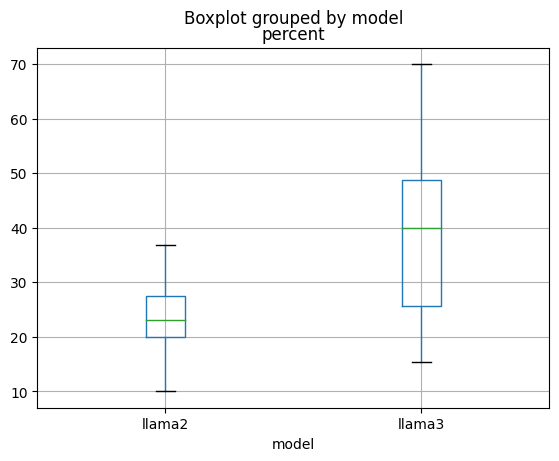

In [12]:
import matplotlib.pyplot as plt

df.boxplot("percent", by="model")
plt.show()

### Plot graphics with tests

In [13]:
tests_dir_path = Path("../../metrics/knowledge_tests/obrazovaka/")
num_questions_in_test = set()
test_lengths = []
for file in tests_dir_path.glob("*.json"):
    with open(file, "r") as f:
        test = json.load(f)
    test_lengths.append(len(test))
    for entry in test:
        num_questions_in_test.add(len(entry["answers"]))

In [39]:
np.mean(test_lengths)

18.6

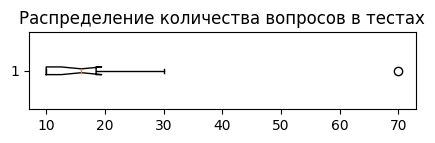

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 1))
plt.boxplot(test_lengths, vert=False, widths=0.05, notch=True)
plt.ylim(ymin=0.75, ymax=1.25)
plt.title("Распределение количества вопросов в тестах")
plt.show()